In [42]:
#Epidemic productions
#@all rights reversed
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

In [43]:
#Paràmetres
#Fricció
mu = 0.03
nu = 0.08

#Condicions inicials
#Temps
temps = 10
stepspersegon = 50

#Espai-Temps (Compte!! el que sé realment a partir de les mesures són r_o i v_o, (i només en el pla x-y)) --> Falta el programa
#del pau que ho aproximava, solucionat
#Les seguents són les mesures de posició i velocitat en el pla XY del centre de masses de la pilota:
[xg, yg] = [0.8,0]
[vxg, vyg] = [0,0] #si el llances des d'una pos amb yg = 0, el codi canviarà una velocitat [0,0] per una que fa orbites circulars
spininicial = 1 # és Rw*s[0]

#Forma del llit (___Funcions___)
k = -0.44
c = -1.8
sigma = 1
sigma2 = sigma**2

In [1]:
#ACHITUNG: Del que hi ha a continuació es necessita substituïr-ho tot per una funció anomenada 'F' que retorna l'altura del llit 
#elàstic en el punt (x,y), i una funció 'derivades_F' que donant-li (x,y) retorni el GradF(x,y) i la HessF(x,y), en aquest ordre. 

#RADI O ANÀLEG
def radius(x,y):
    return np.sqrt(x*x + sigma2*y*y)

#f FUNCIÓ ALTURA (RADIAL)
def f(r):
    return k * np.exp(c*r)
#Derivades de la funció altura respecte el radi r
def df(r):
    return k*c * np.exp(c*r)
def ddf(r):
    return k*c*c * np.exp(c*r)

#la funció F(x,y) és f(r(x,y)), F FUNCIÓ ALTURA DEL PUNT en cartesianes.
def F(x,y):
    return f(radius(x,y));

#DERIVADES PARCIALS DE F
def derivades_F(x, y):
    r = radius(x,y)
    grad_r = np.array([x, sigma2*y])/r
    hess_r = sigma2 * np.array([[y*y, - x*y],
                       [- y*x, x*x]])/r**3
    
    derf = df(r) #derivade de f respecte r
    
    grad_F = derf * grad_r
    hess_F = ddf(r) * np.transpose([grad_r]) * grad_r + derf * hess_r
    
    return grad_F, hess_F

In [45]:
#Part física - constants (SI)
g = 9.81   #obvi, no?
m = 0.8      #pes pilota
R = 0.04     #radi pilota
i = 2/5    #factor del moment d'inercia (I/mR^2)

beta = 1/(1+i)
gamma = i*beta               #factor que apareix en la força final (esfera = 2/7)

In [55]:
#Miscel·lània
#Vector unitari normal
def unit_normal(x,y):
    grad_F, hess_F = derivades_F(x, y)
    n_ = np.append(-grad_F, 1)      #vector normal a la superfície
    n = np.sqrt(np.dot(n_, n_))     #el seu mòdul
    N_ = n_/n                        #Vector normal unitari
    return N_

#Vector unitari normal i la seva derivada temporal
def unit_normals(x, y, vx, vy):
    grad_F, hess_F = derivades_F(x, y)
    n_ = np.append(-grad_F, 1)      #vector normal a la superfície
    n = np.sqrt(np.dot(n_, n_))     #el seu mòdul
    N_ = n_/n                        #Vector normal unitari
    n_t = np.array([-np.dot(hess_F[0], [vx, vy]), 
                    -np.dot(hess_F[1], [vx, vy]),
                   0])              #derivada del vector normal respecte el temps

    N_t = n_t/n - N_/n * np.dot(n_t, N_) #Segur que està bé? np.dot(n_t, N_) ?= parcial_t(n) = 1/n * np.dot(n_t,n_) OK
    
    return N_, N_t

#Deixa només la part ortogonal a n del vector v
def ortogonalitza(v, n):
    """Ortogonalitza v respecte n"""
    return v - np.dot(v,n)*n

#Retorna v_p en funció de r_p i v_o 
# Velocitat de desplaçament del punt de contacte (alerta! No és la velocitat de la bola en el punt de contacte, que és 0),
# en funció de les derivades de la superfície en la seva posició i la velocitat del centre de masses
def vel_p(grad_F, hess_F, v_o):
    n = np.sqrt(np.dot(grad_F, grad_F) + 1) #Mòdul del vector normal
    a, b, c = [-1 - grad_F[1]**2, grad_F[0]* grad_F[1], -1 - grad_F[0]**2]
    
    #solucionem un sistema d'equacions: v_p + R * N_t = v_o (incògnites vx, vy, sudem de la tercera component) 
    #1a equació A*vx + B*vy = v_o[0]
    #2a equació C*vx + D*vy = v_o[1]
    [[A, B], [C,D]] = (R/n**3) * np.dot([[a,b], [b,c]], hess_F) + np.identity(2)  # [[a,b], [b,c]] = n_*n_^t - Id
    
    #Solucionem per gauss: (no seidel) (alerta C i B peetits)
    vy = (v_o[1] - C/A * v_o[0] )/(D - C*B/A)
    vx = (v_o[0] - B*vy)/A 
    
    vz = np.dot(grad_F, [vx, vy]) #¡¡¡¡¡Aquest pas marca el motiu de perquè v_p es comporta tant bé en l'eix z!!!!! 
                                    #(perquè directament busca l'únic vector ortogonal)
                                    #podria calcular-ho per gauss també la tercera component i veure
    return np.array([vx, vy, vz])

#Busca una velocitat que quan no hi ha fricció, i la pilota té R = 0, faci una òrbita circular. N'hi sol haver dues de possibles.
#No sé si cal que el llit sigui circular.
def velocitat_inicial_circular(r, spin):
    fp = df(r)
    b = gamma*spin*abs(fp)
    c = -beta*g*fp*r
    if np.all(b**2 - 4*c) < 0:
        print ("error, yepa, no hi ha orbita (circular?) estable")
        return False
    vpos = (-b + np.sqrt(b**2 - 4*c))/2
    vneg = (-b - np.sqrt(b**2 - 4*c))/2
    return [vpos, vneg]

#Obtenir els vectors de la posició i velocitat del centre de masses inicial
def comprova(res, r_g): #Retorna cert si la solució de numèric és l'esperada
    N = unit_normal(res[0],res[1])
    nr_g = res + R*N[0:2] #No té sentit parlar de quant ens desviem en l'eix z
    #perquè no tenim cap dada original sobre on som en l'eix z, la r_o[2] = r_p[2] + R*N[2]
    return (np.linalg.norm(nr_g[0:2]-r_g) < 1e-10)

#Calcula, en el pla XY, la posició del punt P, donada la posició del punt O
def numeric(xg,yg):
    #Càlculs per introduïr les cond. inicials
    r_g = [xg, yg]
    N = unit_normal(xg,yg)
    res = r_g - R * N[0:2]
    norma_dif = 1
    niter = 0
    while norma_dif > 1e-10 and niter < 30: #a_r guarda la de la iteració anterior
        niter += 1
        ar_p = res
        N = unit_normal(ar_p[0],ar_p[1])
        res = r_g - R * N[0:2]
        norma_dif = np.linalg.norm(res-ar_p)

    if niter == 30: 
        raise Exception("El mètode no ha convergit")

    if not comprova(res, r_g):
        raise Exception("El mètode no ha convergit a un bon lloc")

    return res[0], res[1]

In [53]:
#Calcula les forces sobre el centre de masses O, en retorna l'acceleració
#També fa tangent la velocitat del c.m. a la superfície, i calcula la velocitat del desplaçament de 
# p (punt on es produeix el contacte de la bola amb el terra) en l'espai. 
# (alerta, p no és el punt de la bola en contacte amb el terra, que està instantàniament quiet)

def acc_o(y): #els que porten barra baixa són vectors, els altres, nombres  (per a un cert moment t)
    #Calculem coses bàsiques
    [r_p, r_o, v_o, spin] = y
        #PART no temporal
    (x,y,z) = r_p
    grad_F, hess_F = derivades_F(x, y)
    n_ = np.append(-grad_F, 1)       #vector normal a la superfície
    n = np.sqrt(np.dot(n_, n_))      #el seu mòdul
    N_ = n_/n                        #vector normal unitari         #OBS: vectors en majúscula són unitaris,
                                                                    #vectors amb " _ " tenen 3 components (com ja dit)
    
        #PART 1a derivada temporal
    v_o = ortogonalitza(v_o, N_)     #Correcció ortogonalitat de v_o, ¡pas basto!!
    v_p = vel_p(grad_F, hess_F, v_o) #Càlcul de la velocitat en la superfície del punt de contacte(no del punt de l'esfera/sòlid)
    #Alternativament, calcula la derivada discreta, usant: N_t2  aprox=  N2-N1
    #Haurem de demanar d'entrada el N_ previ (podria entrar r_pi)
    
    (vx,vy,vz) = v_p
    n_t = np.array([-np.dot(hess_F[0], [vx, vy]), 
                    -np.dot(hess_F[1], [vx, vy]),
                   0])               #derivada del vector normal respecte el temps
    
    vo = np.sqrt(np.dot(v_o,v_o))
    V = v_o/vo                       #vector velocitat c.m. unitari 
    
    #r = radius (x,y)
    #print ("vector derivada de n", n_t, "vec velocitat", v_o)
    #print (df(r)*vo/r)
    
    #CALCULEM FORCES
        #Part Normal
    an = - np.dot(v_o, n_t)/n    #acceleració normal, del centre de masses
    Fn = m*(g*N_[2] + an)            #força normal, feta pel llit elàstic (apunt, mgN_[2] és el negatiu de la projecció de 
                                    # la força de la gravetat (-mgZ_) sobre la normal)  
                                    # (no cal calcular-la)
                                    # (potser millor calcular-la a banda, i fer-ne plot)
           
        #Part Tangencial
    g_t = -g * np.array([0,0,1] - N_[2]*N_)           #acceleració tangencial causada per la gravetat (N_[2] = N*[0,0,1] = 1/n)
    F_t = gamma*m * (spin * np.cross(N_, n_t)/n - g_t) #Força "aparent" deguda a la rotació de la pilota,
                                                                      #i la seva fricció amb el terra
    a_t = F_t/m + g_t - mu*Fn*V  #acceleració tangencial, del centre de masses, potser era més ràpid  computacionalment 
                                    #el mètode anterior
    
    #print ('accel spin ',  np.cross(N_, n_t)[2]*n + df(r)**2 * vo / r)
    #print ('vel orthogonality ',  np.dot(N_, n_t))
    
    #Obtenim acceleració
    a_o = a_t + an * N_
    
    #Calculem canvi spin
    vspin = np.linalg.det([n_t, N_, v_o])/n #intentar buscar com fer un determinant
    
    if (abs(spin) > 1e-3):
         vspin = vspin - nu*spin/abs(spin)
    
    return np.array([v_p, v_o, a_o, vspin])

In [56]:
#Definicions/Inicialització

#Part temporal
steps = temps * stepspersegon  #Bàsicament, definim implícitament mida del timestep
mida = steps + 1
tmax = temps   
timestep = tmax/steps
time = np.linspace(0, tmax, mida)


#Part espaial
r_p = np.zeros((mida, 3))    #posició punt contacte
v_p = np.zeros((mida, 3)) 
a_p = np.zeros((mida, 3)) 

r_o = np.zeros((mida, 3))    #posició centre de masses
v_o = np.zeros((mida, 3)) 
a_o = np.zeros((mida, 3)) 

s = np.zeros(mida)          #spin de la pilota (R*ws)
vs = np.zeros(mida)

#Dóna una velocitat raonable sii la velocitat inicial és 0
#if (vxg**2 + vyg**2) == 0 :
#    [vxg, vyg] = [0, velocitat_inicial_circular(xg, spininicial)[0]]
#    print ([vxg, vyg])
    
#Se'ls hi ha de donar valors inicials a r_p, r_o, v_o, s
s[0] = spininicial

#Càlculs per introduïr les cond. inicials
x0, y0 = numeric(xg,yg)  #Mètode iteratiu per a trobar el punt de contacte amb el terra a partir del del c.m.
r_p[0] = [x0, y0, F(x0,y0)]

grad_F, hess_F = derivades_F(x0, y0)
v_o[0] = [vxg, vyg, np.dot(grad_F,[vxg,vyg])]  #Gràcies a que la v_o és tangent a la superfície

N = unit_normal(x0,y0)
r_o[0] = r_p[0] + R * N #Per definició

In [57]:
#Implementem un Runge-Kutta d'ordre 4 general, vectorial
#y = [r_p, r_o, v_o, spin]
#k1 = [v_p, v_o, a_o, vspin]
def RungeKutta4step(y, timestep):
    k1 = acc_o(y)
    k2 = acc_o(y + timestep*0.5*k1)
    k3 = acc_o(y + timestep*0.5*k2)
    k4 = acc_o(y + timestep*k3)
    yf = y + (timestep/6)*(k1 + 2*k2 + 2*k3 + k4)
    return yf, k1

#ªªªªªªªªªªªªªªª#
# Runge - Kutta #
#ªªªªªªªªªªªªªªª#
#preguntar al pau com es feia allò d'ajuntar variables de sortida d'una funció

#recordar y = [r_p, r_o, v_o, spin]

Y = np.array([[r_p[i],r_o[i],v_o[i],s[i]] for i in range(mida)])

for t in range (1, mida):
    #Canvis de nom per a les condicions prèvies / pseudo step1
    Y[t],[v_p[t-1], v_o[t-1], a_o[t-1], vs[t-1]] = RungeKutta4step(Y[t-1], timestep)
#Un crit de la funció més perquè aquests últims valors de les derivades no es necessiten per a fer cap càlcul:
[v_p[steps], v_o[steps], a_o[steps], vs[steps]] = acc_o(Y[steps]) 

#De fet, les derivades que ens guardem són simplement per una qüestió de poder-les analitzar posteriorment, de fet 

#Formatejar les dades per a que es reconeguin com als vectors declarats al principi
Ytranspost = np.transpose(Y)
r_pr = Ytranspost[0]
r_or = Ytranspost[1]
v_or = Ytranspost[2]
sr = Ytranspost[3]

for i in range (mida):
    r_p[i] = r_pr[i]
    r_o[i] = r_or[i]
    v_o[i] = v_or[i]
    s[i] = sr[i]

In [58]:
#Formatting the output
W = np.transpose([time, s, vs])
N_ = np.zeros((mida, 3))
N_t = np.zeros((mida, 3))
for t in range (0, mida):
    N_[t], N_t[t] = unit_normals(r_p[t,0], r_p[t,1], v_p[t,0], v_p[t,1])

#Escollir el nom de l'arxiu  
file_name = '3.2-tmax = {tmax}, timestep = {timestep}, spin = {s}, sigma = {sig}' \
             .format(tmax = str(tmax), timestep = str(timestep), s = str(s[0]), sig = str(sigma))

#Escollir què surt
np.savetxt(file_name, np.concatenate((W, r_p, v_p, r_o, v_o, a_o, N_, N_t), 1) , delimiter=", ", 
           header = 'time,spin,vspin,rpx,rpy,rpz,vpx,vpy,vpz,rox,roy,roz,vox,voy,voz,aox,aoy,aoz,Nx,Ny,Nz,Ntx,Nty,Ntz')

np.savetxt("workfile.txt", np.concatenate((W, r_p, v_p, r_o, v_o, a_o, N_, N_t), 1) , delimiter=", ", 
           header = 'time,spin,vspin,rpx,rpy,rpz,vpx,vpy,vpz,rox,roy,roz,vox,voy,voz,aox,aoy,aoz,Nx,Ny,Nz,Ntx,Nty,Ntz')

In [59]:
file_name

'3.2-tmax = 10, timestep = 0.02, spin = 1.0, sigma = 1'

CURIOSITAT (IMPORTANT), passar molt a prop del centre no causa errors en la trajectòria, només en causa en l'altura -> causa només errors en l'Energia potencial

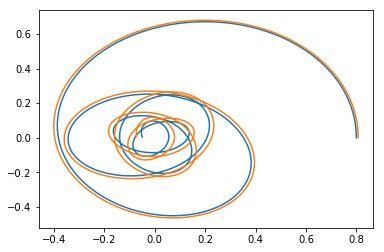

In [60]:
plt.plot(r_o[:,0], r_o[:,1])
plt.plot(r_p[:,0], r_p[:,1])
plt.savefig(file_name + ' grafic.png')
plt.show()